# Задание 1


### Целью этого задания является знакомство со стандартными контейнерами и некторыми функциями из стандартных библиотек для машинного обучения.

Напишите наивный байесовский классификатор и сравните его с реализацией NaiveBayesClassifier из библиотеки nltk.

Написанный вами классификатор должен обладать следубщими свойствами:
<ul>
<li>В предложенном интерфейсе класса должны быть реализованы все методы и все поля. Для их хранения предподсчитанных данных рекомендуется использовать контейнеры Counter или defaultdict из библиотеки collections. Для предсказания категории рекомендуется использовать numpy.</li>
<li>Должна использоваться модель, предложенная в теории.</li>
<li>Точность предсказаний не менее <b>0.9</b>!</li>
<li>После реализации класса протестируйте его с помощью кроссвалидации с k=10. Рекомендуется использовать класс KFold из библиотеки sklearn.</li>
<li>Постройте постройте диаграмму размаха для классификаторов (своего и из библиотеки).</li>
</ul>

### Теория

Теория находится в файле problems1-theory.pdf

# Решение

In [1]:
import pandas as pd
import numpy as np
from math import log
from collections import Counter, defaultdict
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from matplotlib import pyplot as plt

%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Прочитайте данные из файла

In [2]:
data_path = "ham-spam.csv"

In [3]:
# TODO: your code here
data = pd.read_csv(data_path, header=0)

In [4]:
print(data.dtypes)
data.head()

target    object
msg       object
dtype: object


,target,msg
0,ham,Subject : re : 2 . 882 s - > np np > date : su...
1,ham,Subject : s - > np + np the discussion of s - ...
2,ham,Subject : 2 . 882 s - > np np . . . for me it ...
3,ham,"Subject : gent conference "" for the listserv ""..."
4,ham,Subject : query : causatives in korean could a...


### Реализуйте все методы в классе NaiveBayes

In [5]:
class NaiveBayes(object):
    """
    Наивный байесовский классификатор.
    Для каждого входного сообщения слово учитывается один раз при расчете итоговой вероятности.

    Parameters
    ----------
    category_priors : default | None, optional, default None
        Априорные вероятности категорий.
        Если None, то классификатор должен сам их вычислить.

    weight : float, optional, default 1
        Вес одного слова в формуле взвешенной вероятности

    supposed_prob : float, optional, default 0.5
        Предполагаемая вероятность слова в категории
    """

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        self.category_priors = category_priors
        self.weight = weight
        self.supposed_prob = supposed_prob      
        
    def fit(self, x_train, y_train):
        """
        Производит обучение наивного байесовского классификатора.

        Parameters
        ----------
        x_train : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        y_train : list of str
            содержит список меток (названий категорий) для сообщений из x_train

        Returns
        -------
        self : object
            Returns self
        """
        # Подсчитываем количество категорий, документов и слов в каждой категории
        # и количество встреч слова во всех сообщениях
        
        y_train_pd = pd.Series(y_train)
        x_train = np.array(x_train)
        
        # список категорий
        self.cat_list = self.get_categories(y_train)
           
        # все сообщения для данной категории
        cat_msgs = defaultdict(str) 
        
        # получаем все сообщения из данной категории
        for cat in self.cat_list:
            # находим индексы сообщений с данными категориями
            indexes = y_train_pd[y_train_pd==cat].index
            msgs = np.array(x_train[indexes])
            unique_msgs = []
            # из каждого сообщения выделяем уникальные слова
            for i in range(len(msgs)):
                unique_msgs.append(np.unique(msgs[i].split(" "))) 
            # соединяем все сообщения один массив
            if (len(unique_msgs) != 0):
               unique_msgs = np.hstack(unique_msgs)
            cat_msgs[cat] = unique_msgs

        # Количество отдельных слов в заданной категории
        self.feature_category_counts = Counter()
        for cat in self.cat_list:
            self.feature_category_counts[cat] = len(cat_msgs[cat])
            
        # Количество всех документов в данной категории
        self.category_doc_counts = Counter()
        for cat in self.cat_list:
            # Количество всех документов в данной категории
            self.category_doc_counts[cat]=len(y_train_pd[y_train_pd==cat])
        
        # все сообщения
        all_msgs = []
        for cat in self.cat_list:
            all_msgs += list(cat_msgs[cat])

        # Количество встреч слова во всех сообщениях
        self.feature_counts = Counter(all_msgs)

        # Если априорные вероятности категорий не заданы, то надо аппроксимировать их
        if (self.category_priors == None):
            self.category_priors = Counter()
            for cat in self.cat_list:
                self.category_priors[cat] = len(y_train_pd[y_train_pd==cat])/len(y_train_pd)
                
        # Количество встреч слова во всех сообщениях заданной категории
        self.feature_cat_counts = Counter(Counter())
        for cat in self.cat_list:
            self.feature_cat_counts[cat] = Counter(cat_msgs[cat])
        
        return self

    def predict(self, text):
        """
        Предсказывает метки категорий для text.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        categories : list of str
            Возвращает названия категорий для text.
        """
        categories = []
        
        # тут разбор случаев для типа text
        if (type(text)==str):
            
            text = np.unique(text.split(" "))
            # индекс наиболее подходящей категории
            cat_index = np.argmax(self.get_probs(text))
            categories.append(self.cat_list[cat_index])
        
        elif (type(text)==list):
            
            is_str = False
            
            for subtext in text:
                subtext = np.unique(subtext.split(" "))
                # индекс наиболее подходящей категории
                cat_index = np.argmax(self.get_probs(subtext))
                categories.append(self.cat_list[cat_index])

        return categories

    def score(self, text, labels):
        """
        Возвращает точность предсказаний на text для правильных категорий labels.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.
        labels : list of str
            Список категорий для каждого токена из text.

        Returns
        -------
        acc : float
            Точность предсказания.
        """
        # получаем предсказанные категории для текста
        pred_cat = self.predict(text)
        
        assert(len(labels)==len(pred_cat))
        
        counter = 0
        for ind in range(len(labels)):
            if (labels[ind]==pred_cat[ind]):
                counter += 1
                
        acc = counter/len(labels)
        return acc

    def get_probs(self, text):
        """
        Считает вероятности принадлежности текста (text) к каждой из категорий

        Parameters
        ----------
        text : list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.

        Returns
        -------
        probs : list of float
            Возвращает вероятности probs всех категорий для текста text
            в порядке их следования в self.category_doc_counts.
        """
        # Токенизируем текст, если это необходимо
        if (type(text) == str):
            text = text.split(" ")
           
        probs = []
        for cat in self.cat_list:
            probs.append(self.get_category_prob(cat, text))

        return probs

    def get_category_prob(self, cat, text):
        """
        Считает логарифм вероятность принадлежности сообщения text к категории cat.

        Parameters
        ----------
        cat : str
            Название категории.

        text : list of str
            Список из слов.

        Returns
        -------
        log_prob : float
            Возвращает логарифм вероятности категории cat для текста text.
        """
        # вероятность того что текст, содержащий слова token, принадлежит категории cat
        features_prob = 1
        for token in text:
            weighted_feature_prob = self.get_weighted_feature_prob(cat, token)
            features_prob *= weighted_feature_prob
            
        # логарифм вероятность принадлежности сообщения text к категории cat 
        # это априорная вероятность категории на вероятность того, что текст принадлежит категории cat
        log_prob = log(self.category_priors[cat])+log(features_prob)

        return log_prob

    def get_weighted_feature_prob(self, cat, feature):
        """
        Вычисляет взвешенную вероятность P(Слово|Категория).

        Parameters
        ----------
        cat : str
            Название категории.

        feature : str
            Слово из текста.

        Returns
        -------
        prob : float
            Возвращает взвешенную вероятность слова feature при условии категории cat.
        """
        P_a = 0.5
        
        # количество встреч слова во всех сообщениях заданной категории
        
        #  P_feat_cat - вероятность того, что сообщение категории cat содержит слово feature - 
        # это количество сообщений категории cat, содержащих слово feature, 
        # делённое на количество сообщений категории cat
        P_feat_cat = self.feature_cat_counts[cat][feature]/self.category_doc_counts[cat]
        
        # взвешенная вероятность
        prob = (self.weight * P_a+self.feature_category_counts[cat]*P_feat_cat)/(self.weight+self.feature_category_counts[cat])

        return prob

    def get_categories(self, y_train):
        """
        Возвращает список названий всех категорий.
        Returns
        -------
        cat_list : list of str
        """
        self.cat_list = np.unique(y_train)
        return self.cat_list
pass


### Сравните вашу реализацию и реализацию из библиотеки nltk

Для использования классификатора из библиотеки не забудьте предподготовить данные. Для подсчета точности этого классификатора можете использовать accuracy_score из метрик sklearn. Для подсчета точности предсказаний вашего классификатора используйте функцию score, которую вы опишете.

In [6]:
X = data['msg']
y = data['target']

In [13]:
# Предобработка данных для классификатора nltk, если требуется

# возвращает список пар (msg, target) для NaiveBayesClassifier.train
def get_labeled_feat(X, y):
    labeled_feat = []
    for msg, target in zip(X, y):
        msg = msg.split(" ")
        msg = Counter(msg)
        labeled_feat.append([msg, target])
    return labeled_feat 

# возвращает количество встреч слова в каждом сообщении из X для NaiveBayesClassifier.classify_many
def get_feature_sets(X):
    feature_sets = []
    for msg in X:
        msg = msg.split(" ")
        msg = Counter(msg)
        feature_sets.append(msg)
    return feature_sets

In [14]:
# score нашего классификатора и nltk.Naive....
m_score = []
nltk_score = []

In [15]:
%%time
# Используйте процедуру KFold для проверки качества классификаторов
kf = KFold(len(X), n_folds=10)
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # получим score от своего классификатора
    mClassifier = NaiveBayes()
    mClassifier.fit(list(X_train), list(y_train))
    m_score.append(mClassifier.score(list(X_test), list(y_test)))
    
    # получим score от классификатора из nltk
    nltkClassifier = NaiveBayesClassifier.train(get_labeled_feat(X_train, y_train))
    y_pred = nltkClassifier.classify_many(get_feature_sets(X_test))
    nltk_score.append(accuracy_score(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:221: RuntimeWarning: divide by zero encountered in log


Wall time: 1min 7s


### Сравним результаты работы классификаторы из nltk и нашего

In [16]:
print("our classifier mean: ", np.array(m_score).mean())
print("nltk classifier mean: ", np.array(nltk_score).mean())

our classifier mean:  0.936389452333
nltk classifier mean:  0.966125760649


### В среднем наш работает лучше

### Постройте графики размаха для двух классификаторов на одной фигуре.

Рекомендуется использовать встроенные функции построения графиков в pandas.

In [17]:
m_score = pd.Series(m_score)
nltk_score =  pd.Series(nltk_score)

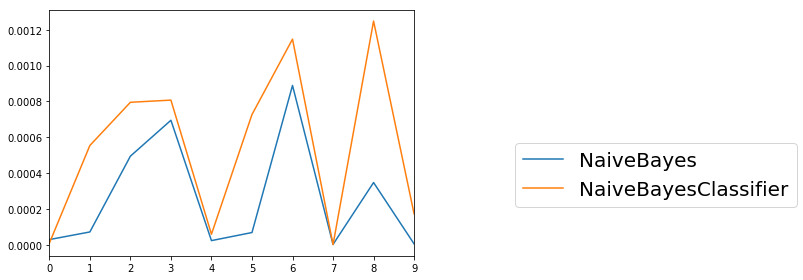

In [18]:
# строим график дисперсии
((m_score-m_score.mean())**2).plot(label="NaiveBayes")
((nltk_score-nltk_score.mean())**2).plot(label="NaiveBayesClassifier")

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()

В среднем отклонение у нашего классификатора меньше